In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
import hdbscan
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Modern aesthetics
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
COLORS = sns.color_palette("husl", 12)

In [2]:
# === Configuration ===
HOME = Path.home()
REPO_ROOT = HOME / "Uni-stuff/semester-2/applied_Ml/reef_zmsc"
INPUT_FILE = REPO_ROOT / "data/features/embeds_preprocessed_50k/preprocessed_features_pca.parquet"
OUTPUT_BASE = REPO_ROOT / "data/clustering/results_50k"

# Clustering parameters
K_RANGE = range(3, 21)  # Try K from 3 to 20 for K-means
RANDOM_STATE = 42

In [3]:
def load_preprocessed_data():
    """Load the PCA-reduced features."""
    print("📂 Loading preprocessed data...")
    
    df = pd.read_parquet(INPUT_FILE)
    
    # Separate metadata, PCA features, and UMAP coordinates
    metadata_cols = ['filepath', 'start_s', 'end_s', 'logger', 'date']
    umap_cols = ['umap_x', 'umap_y']
    pca_cols = [c for c in df.columns if c.startswith('pca_')]
    
    metadata = df[metadata_cols].copy()
    umap_coords = df[umap_cols].copy()
    features = df[pca_cols].copy()
    
    print(f"   ✓ Loaded {len(df):,} clips")
    print(f"   ✓ PCA features: {len(pca_cols)} dimensions")
    print(f"   ✓ Loggers: {metadata['logger'].nunique()}")
    print(f"   ✓ Dates: {metadata['date'].nunique()}")
    
    return metadata, features, umap_coords

In [15]:
def find_optimal_k_elbow(features, k_range, output_dir):
    """Find optimal K using elbow method."""
    print(f"\n🔍 Finding optimal K using elbow method (K={min(k_range)} to {max(k_range)})...")
    
    inertias = []
    silhouette_scores = []
    davies_bouldin_scores = []
    calinski_harabasz_scores = []
    
    for k in tqdm(k_range, desc="Testing K values"):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        labels = kmeans.fit_predict(features)
        
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(features, labels))
        davies_bouldin_scores.append(davies_bouldin_score(features, labels))
        calinski_harabasz_scores.append(calinski_harabasz_score(features, labels))
    
    # Plot all metrics
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('K-Means: Optimal Cluster Number Selection', fontsize=16, fontweight='bold')
    
    # 1. Elbow curve (Inertia)
    axes[0, 0].plot(k_range, inertias, marker='o', linewidth=2, markersize=8, color=COLORS[0])
    axes[0, 0].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Inertia (Within-cluster Sum of Squares)', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Elbow Method', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Silhouette score (higher is better)
    axes[0, 1].plot(k_range, silhouette_scores, marker='o', linewidth=2, markersize=8, color=COLORS[1])
    best_k_sil = list(k_range)[np.argmax(silhouette_scores)]
    axes[0, 1].axvline(best_k_sil, color='red', linestyle='--', linewidth=2, 
                       label=f'Best K={best_k_sil}')
    axes[0, 1].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Silhouette Score (Higher = Better)', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Davies-Bouldin index (lower is better)
    axes[1, 0].plot(k_range, davies_bouldin_scores, marker='o', linewidth=2, markersize=8, color=COLORS[2])
    best_k_db = list(k_range)[np.argmin(davies_bouldin_scores)]
    axes[1, 0].axvline(best_k_db, color='red', linestyle='--', linewidth=2,
                       label=f'Best K={best_k_db}')
    axes[1, 0].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Davies-Bouldin Index', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Davies-Bouldin Index (Lower = Better)', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Calinski-Harabasz score (higher is better)
    axes[1, 1].plot(k_range, calinski_harabasz_scores, marker='o', linewidth=2, markersize=8, color=COLORS[3])
    best_k_ch = list(k_range)[np.argmax(calinski_harabasz_scores)]
    axes[1, 1].axvline(best_k_ch, color='red', linestyle='--', linewidth=2,
                       label=f'Best K={best_k_ch}')
    axes[1, 1].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Calinski-Harabasz Score', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Calinski-Harabasz Score (Higher = Better)', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_dir / '01_optimal_k_selection.png', dpi=300, bbox_inches='tight')
    plt.show()  # Display in notebook

    
    print(f"   ✓ Best K by Silhouette: {best_k_sil}")
    print(f"   ✓ Best K by Davies-Bouldin: {best_k_db}")
    print(f"   ✓ Best K by Calinski-Harabasz: {best_k_ch}")
    
    # Return metrics dict
    metrics = {
        'k_values': list(k_range),
        'inertias': inertias,
        'silhouette': silhouette_scores,
        'davies_bouldin': davies_bouldin_scores,
        'calinski_harabasz': calinski_harabasz_scores,
        'best_k_silhouette': best_k_sil,
        'best_k_davies_bouldin': best_k_db,
        'best_k_calinski_harabasz': best_k_ch
    }
    
    return metrics



def cluster_kmeans(features, n_clusters):
    """Perform K-means clustering."""
    print(f"\n🎯 Running K-means with K={n_clusters}...")
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(features)
    
    # Calculate metrics
    silhouette = silhouette_score(features, labels)
    davies_bouldin = davies_bouldin_score(features, labels)
    calinski_harabasz = calinski_harabasz_score(features, labels)
    
    print(f"   ✓ Silhouette score: {silhouette:.3f}")
    print(f"   ✓ Davies-Bouldin index: {davies_bouldin:.3f}")
    print(f"   ✓ Calinski-Harabasz score: {calinski_harabasz:.1f}")
    
    return labels, kmeans, {
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski_harabasz': calinski_harabasz
    }


In [17]:
def cluster_hdbscan(features, min_cluster_size=50):
    """Perform HDBSCAN clustering."""
    print(f"\n🎯 Running HDBSCAN (min_cluster_size={min_cluster_size})...")
    
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=10,
        metric='euclidean',
        cluster_selection_method='eom'
    )
    labels = clusterer.fit_predict(features)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)
    
    print(f"   ✓ Found {n_clusters} clusters")
    print(f"   ✓ Noise points: {n_noise:,} ({n_noise/len(labels)*100:.1f}%)")
    
    # Calculate metrics (excluding noise points)
    if n_clusters > 1:
        mask = labels != -1
        if np.sum(mask) > 0:
            silhouette = silhouette_score(features[mask], labels[mask])
            davies_bouldin = davies_bouldin_score(features[mask], labels[mask])
            calinski_harabasz = calinski_harabasz_score(features[mask], labels[mask])
            
            print(f"   ✓ Silhouette score: {silhouette:.3f}")
            print(f"   ✓ Davies-Bouldin index: {davies_bouldin:.3f}")
            print(f"   ✓ Calinski-Harabasz score: {calinski_harabasz:.1f}")
        else:
            silhouette = davies_bouldin = calinski_harabasz = np.nan
    else:
        silhouette = davies_bouldin = calinski_harabasz = np.nan
    
    return labels, clusterer, {
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski_harabasz': calinski_harabasz
    }


In [11]:
def cluster_gmm(features, n_components):
    """Perform Gaussian Mixture Model clustering."""
    print(f"\n🎯 Running GMM with {n_components} components...")
    
    gmm = GaussianMixture(
        n_components=n_components,
        covariance_type='full',
        random_state=RANDOM_STATE,
        n_init=10
    )
    gmm.fit(features)
    labels = gmm.predict(features)
    probas = gmm.predict_proba(features)
    
    # Calculate metrics
    silhouette = silhouette_score(features, labels)
    davies_bouldin = davies_bouldin_score(features, labels)
    calinski_harabasz = calinski_harabasz_score(features, labels)
    
    # Calculate average probability (confidence)
    max_probas = np.max(probas, axis=1)
    avg_confidence = np.mean(max_probas)
    
    print(f"   ✓ Silhouette score: {silhouette:.3f}")
    print(f"   ✓ Davies-Bouldin index: {davies_bouldin:.3f}")
    print(f"   ✓ Calinski-Harabasz score: {calinski_harabasz:.1f}")
    print(f"   ✓ Average confidence: {avg_confidence:.3f}")
    
    return labels, gmm, probas, {
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski_harabasz': calinski_harabasz,
        'avg_confidence': avg_confidence
    }

In [18]:
def plot_clusters_umap(umap_coords, labels, metadata, title, output_path):
    """Plot clusters on UMAP space."""
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # Left: All clusters
    for label in unique_labels:
        mask = labels == label
        if label == -1:
            # Noise points (for HDBSCAN)
            axes[0].scatter(umap_coords.loc[mask, 'umap_x'], umap_coords.loc[mask, 'umap_y'],
                          alpha=0.3, s=1, c='gray', label='Noise')
        else:
            color = COLORS[label % len(COLORS)]
            axes[0].scatter(umap_coords.loc[mask, 'umap_x'], umap_coords.loc[mask, 'umap_y'],
                          alpha=0.5, s=2, c=[color], label=f'Cluster {label}')
    
    axes[0].set_xlabel('UMAP 1', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('UMAP 2', fontsize=12, fontweight='bold')
    axes[0].set_title('Clusters in UMAP Space', fontsize=14, fontweight='bold')
    axes[0].legend(markerscale=5, ncol=2)
    axes[0].grid(True, alpha=0.3)
    
    # Right: Density by cluster
    h = axes[1].hexbin(umap_coords['umap_x'], umap_coords['umap_y'],
                       C=labels, reduce_C_function=np.mean,
                       gridsize=50, cmap='viridis', mincnt=1)
    axes[1].set_xlabel('UMAP 1', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('UMAP 2', fontsize=12, fontweight='bold')
    axes[1].set_title('Cluster Density Heatmap', fontsize=14, fontweight='bold')
    plt.colorbar(h, ax=axes[1], label='Average Cluster ID')
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()  # Display in notebook

In [19]:
def plot_cluster_analysis(labels, metadata, output_path):
    """Analyze cluster composition."""
    df = pd.DataFrame({
        'cluster': labels,
        'logger': metadata['logger'].values,
        'date': metadata['date'].values
    })
    
    # Remove noise if present
    df_clean = df[df['cluster'] != -1].copy()
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('Cluster Composition Analysis', fontsize=16, fontweight='bold')
    
    # 1. Cluster sizes
    cluster_sizes = df_clean['cluster'].value_counts().sort_index()
    axes[0, 0].bar(cluster_sizes.index, cluster_sizes.values, 
                   color=[COLORS[i % len(COLORS)] for i in cluster_sizes.index],
                   alpha=0.7, edgecolor='black', linewidth=1.5)
    axes[0, 0].set_xlabel('Cluster ID', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Number of Clips', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Cluster Sizes', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, v in enumerate(cluster_sizes.values):
        axes[0, 0].text(cluster_sizes.index[i], v + max(cluster_sizes.values)*0.01, 
                       f'{v:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # 2. Clusters per logger
    pivot_logger = df_clean.groupby(['logger', 'cluster']).size().unstack(fill_value=0)
    pivot_logger.plot(kind='bar', stacked=True, ax=axes[0, 1], 
                     color=[COLORS[i % len(COLORS)] for i in range(len(pivot_logger.columns))],
                     alpha=0.7, edgecolor='black', linewidth=0.5)
    axes[0, 1].set_xlabel('Logger', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Number of Clips', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Cluster Distribution per Logger', fontsize=14, fontweight='bold')
    axes[0, 1].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 1].tick_params(axis='x', rotation=0)
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # 3. Temporal distribution
    df_clean['date_dt'] = pd.to_datetime(df_clean['date'], format='%Y%m%d')
    
    for cluster_id in sorted(df_clean['cluster'].unique()):
        cluster_data = df_clean[df_clean['cluster'] == cluster_id]
        date_counts = cluster_data.groupby('date_dt').size()
        axes[1, 0].plot(date_counts.index, date_counts.values, 
                       label=f'Cluster {cluster_id}',
                       color=COLORS[cluster_id % len(COLORS)],
                       linewidth=2, alpha=0.7)
    
    axes[1, 0].set_xlabel('Date', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Number of Clips', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Temporal Distribution of Clusters', fontsize=14, fontweight='bold')
    axes[1, 0].legend(ncol=2)
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Cluster proportion heatmap (cluster vs logger)
    pivot_prop = df_clean.groupby(['cluster', 'logger']).size().unstack(fill_value=0)
    pivot_prop_norm = pivot_prop.div(pivot_prop.sum(axis=1), axis=0) * 100
    
    sns.heatmap(pivot_prop_norm, annot=True, fmt='.1f', cmap='YlOrRd',
               ax=axes[1, 1], cbar_kws={'label': 'Percentage (%)'},
               linewidths=0.5, linecolor='gray')
    axes[1, 1].set_xlabel('Logger', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Cluster', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Cluster Composition by Logger (%)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()  # Display in notebook

In [20]:
def save_clustering_results(metadata, features, labels, algorithm_name, output_dir):
    """Save clustering results to parquet."""
    results_df = pd.concat([
        metadata.reset_index(drop=True),
        pd.DataFrame({'cluster': labels}, index=metadata.index)
    ], axis=1)
    
    output_file = output_dir / f"clustered_data_{algorithm_name}.parquet"
    results_df.to_parquet(output_file, index=False, compression='snappy')
    
    print(f"   ✓ Saved clustering results: {output_file.name}")
    
    return output_file

def create_clustering_report(all_results, output_dir):
    """Create comprehensive clustering report."""
    report_path = output_dir / "clustering_summary.txt"
    
    with open(report_path, 'w') as f:
        f.write("=" * 70 + "\n")
        f.write("CLUSTERING ANALYSIS SUMMARY\n")
        f.write("=" * 70 + "\n\n")
        
        for algo_name, result in all_results.items():
            f.write(f"\n{algo_name.upper()}\n")
            f.write("-" * 70 + "\n")
            
            if 'n_clusters' in result['metrics']:
                f.write(f"Number of clusters: {result['metrics']['n_clusters']}\n")
            
            if 'n_noise' in result['metrics']:
                f.write(f"Noise points: {result['metrics']['n_noise']:,}\n")
            
            f.write(f"Silhouette score: {result['metrics'].get('silhouette', 'N/A'):.3f}\n")
            f.write(f"Davies-Bouldin index: {result['metrics'].get('davies_bouldin', 'N/A'):.3f}\n")
            f.write(f"Calinski-Harabasz score: {result['metrics'].get('calinski_harabasz', 'N/A'):.1f}\n")
            
            if 'avg_confidence' in result['metrics']:
                f.write(f"Average confidence: {result['metrics']['avg_confidence']:.3f}\n")
            
            # Cluster sizes
            unique_labels = np.unique(result['labels'])
            f.write(f"\nCluster sizes:\n")
            for label in sorted(unique_labels):
                if label != -1:
                    count = np.sum(result['labels'] == label)
                    f.write(f"  Cluster {label}: {count:,} clips ({count/len(result['labels'])*100:.1f}%)\n")
        
        f.write("\n" + "=" * 70 + "\n")
        f.write("RECOMMENDATION\n")
        f.write("-" * 70 + "\n")
        f.write("Based on the metrics:\n")
        f.write("- Silhouette score: Higher is better (range: -1 to 1)\n")
        f.write("- Davies-Bouldin index: Lower is better\n")
        f.write("- Calinski-Harabasz score: Higher is better\n")
        f.write("\nConsider the algorithm with the best balance of these metrics.\n")
        f.write("HDBSCAN is good if you want to find natural clusters and handle noise.\n")
        f.write("K-means is good for well-separated, spherical clusters.\n")
        f.write("GMM is good for overlapping clusters with uncertainty.\n")
    
    print(f"   ✓ Saved clustering report")

CLUSTERING ANALYSIS: K-Means, HDBSCAN, GMM
📂 Loading preprocessed data...
   ✓ Loaded 50,000 clips
   ✓ PCA features: 39 dimensions
   ✓ Loggers: 2
   ✓ Dates: 271

STEP 1: Finding Optimal K

🔍 Finding optimal K using elbow method (K=3 to 20)...


Testing K values: 100%|██████████| 18/18 [07:51<00:00, 26.18s/it]


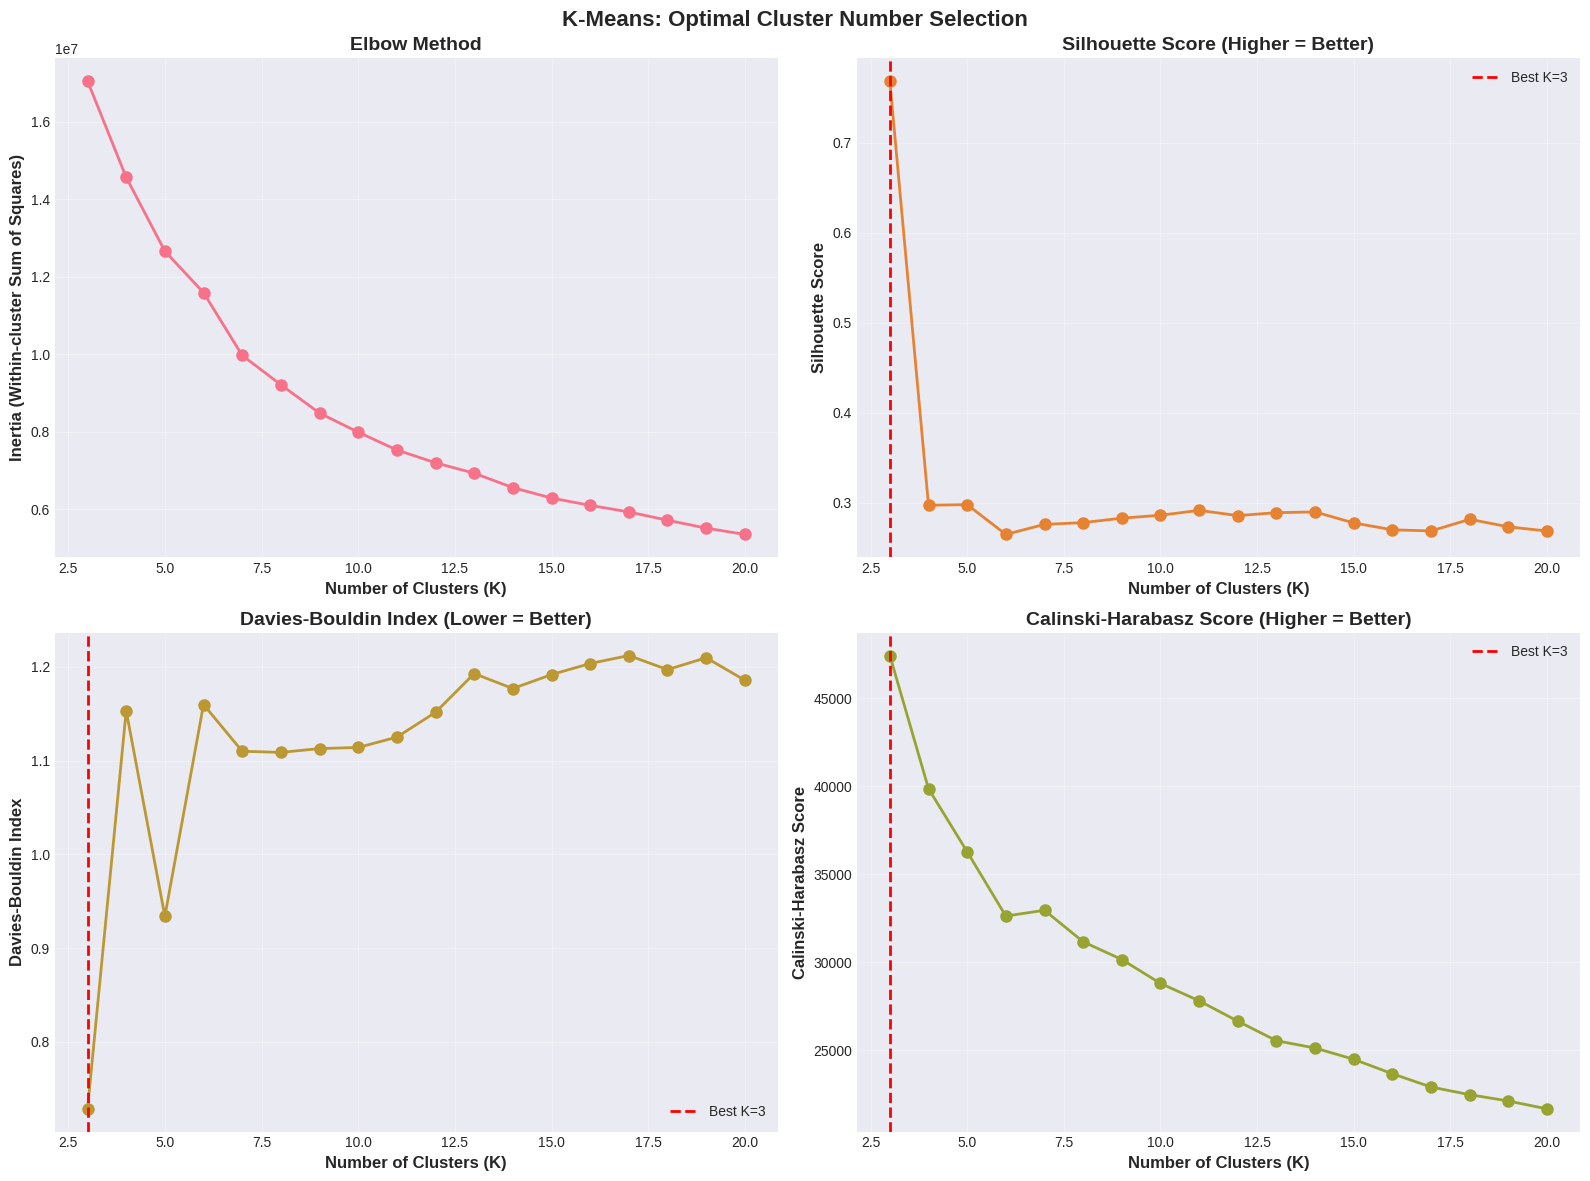

   ✓ Best K by Silhouette: 3
   ✓ Best K by Davies-Bouldin: 3
   ✓ Best K by Calinski-Harabasz: 3

💡 Recommended K for K-means: 3

STEP 2: K-Means Clustering

🎯 Running K-means with K=3...
   ✓ Silhouette score: 0.769
   ✓ Davies-Bouldin index: 0.729
   ✓ Calinski-Harabasz score: 47437.2

📊 Visualizing K-means clusters...


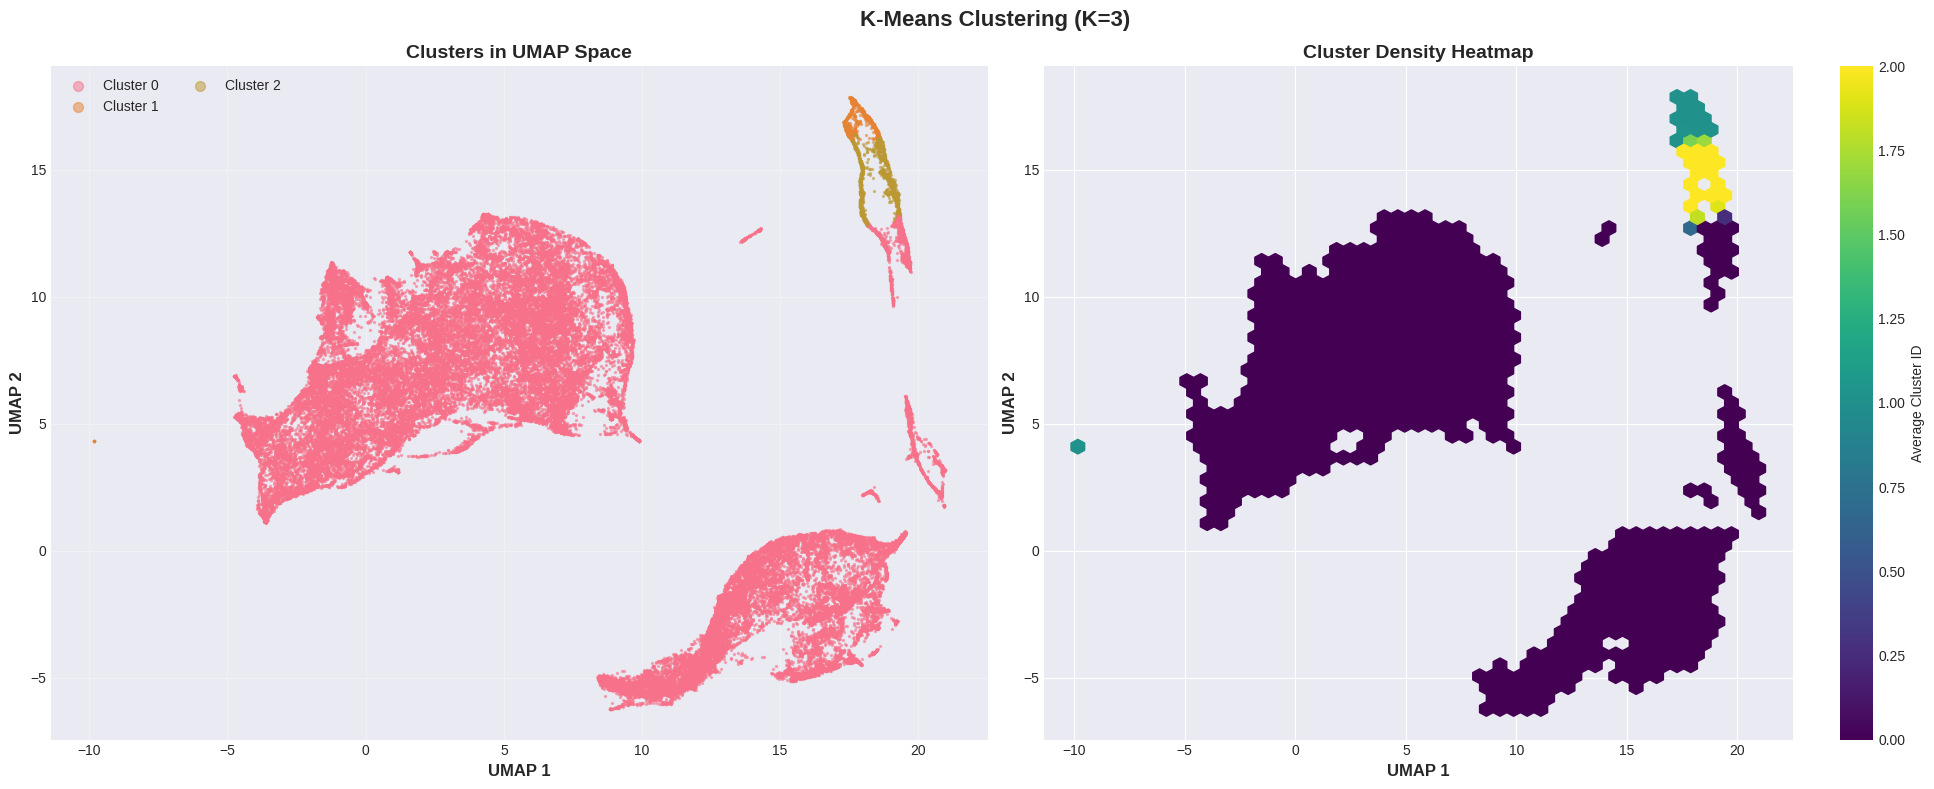

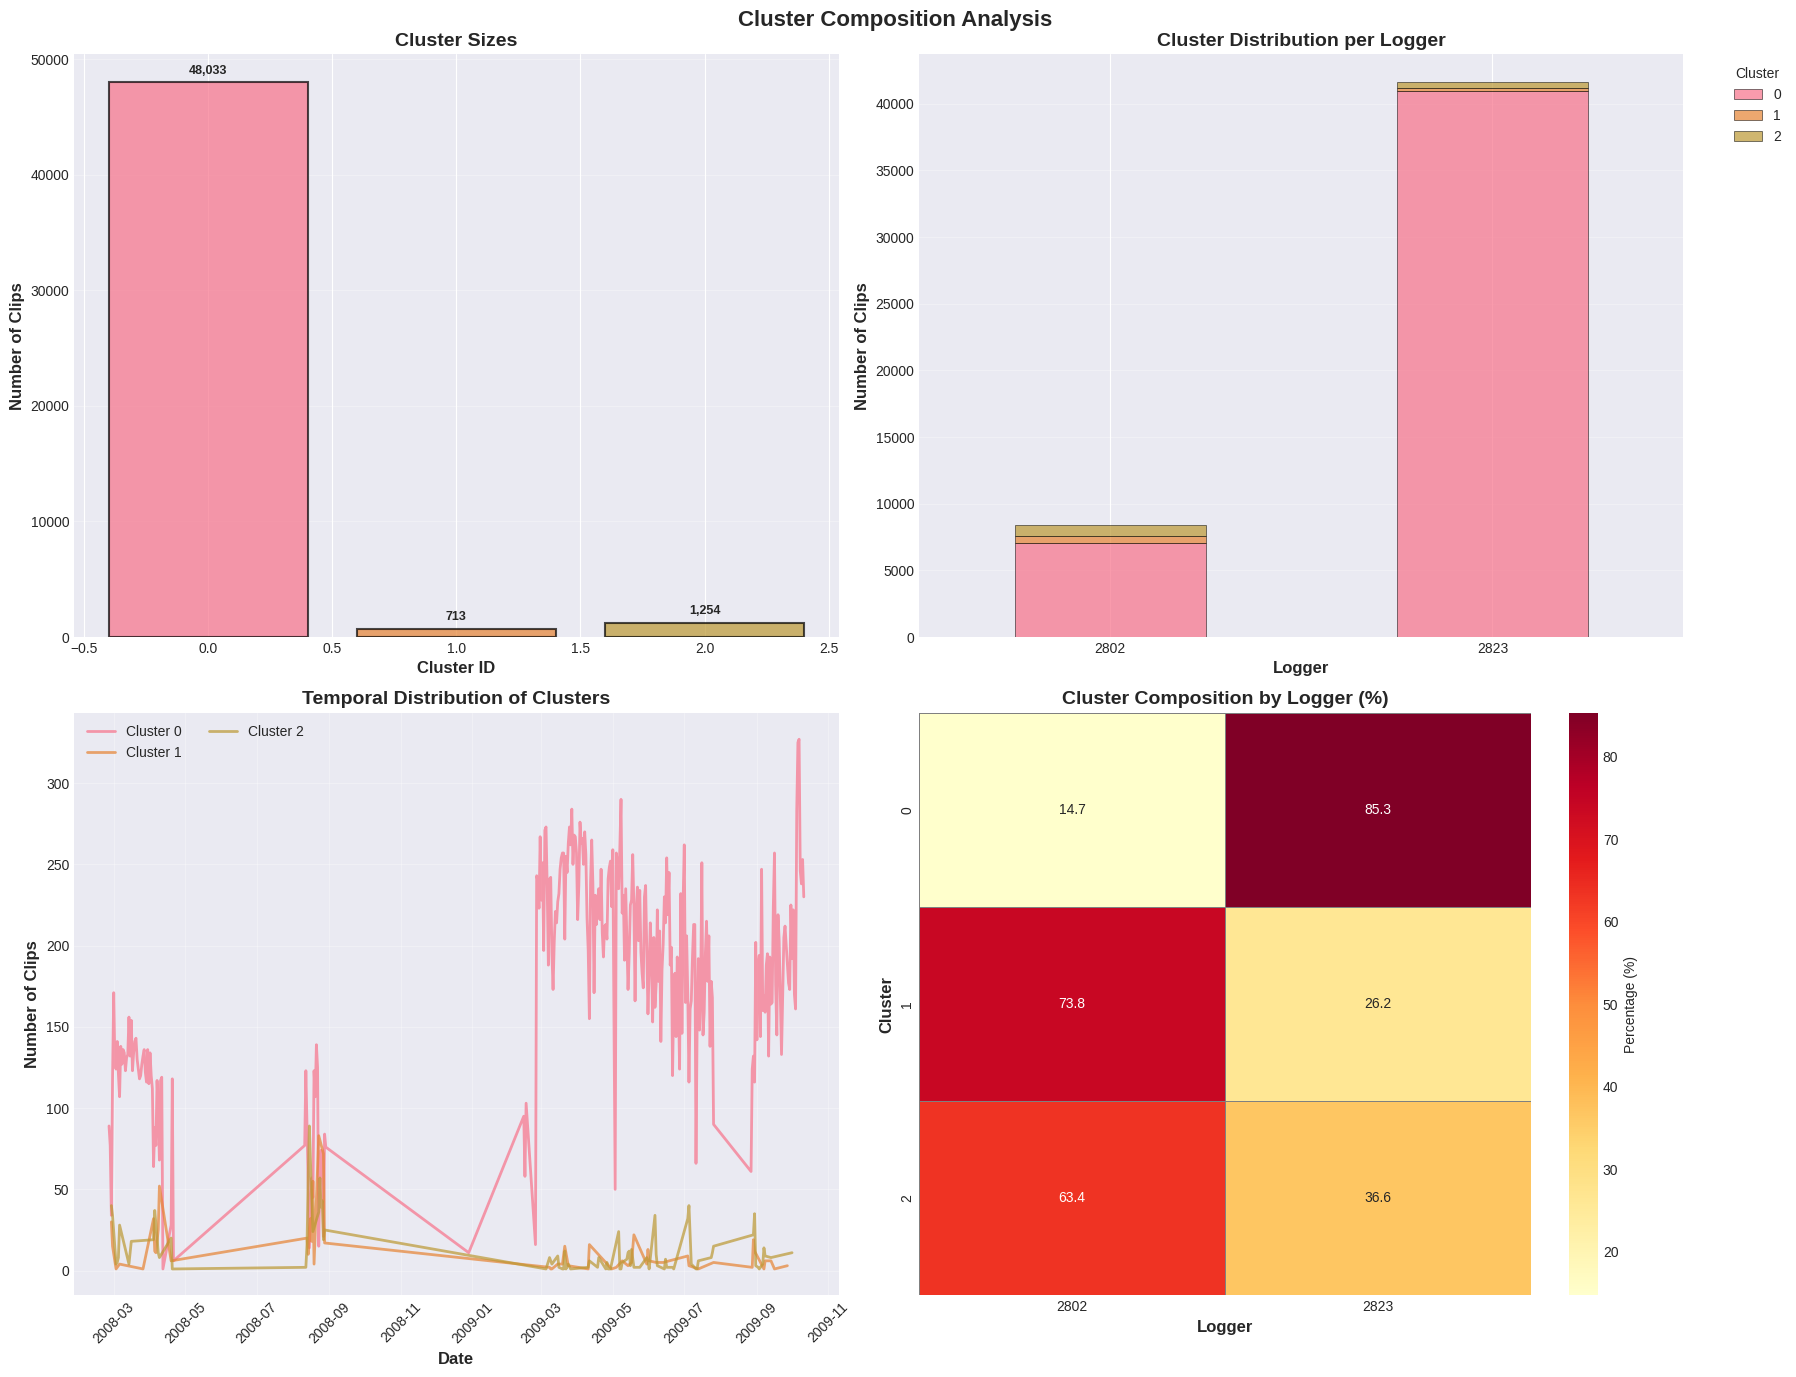

   ✓ Saved clustering results: clustered_data_kmeans.parquet

STEP 3: HDBSCAN Clustering

🎯 Running HDBSCAN (min_cluster_size=50)...
   ✓ Found 4 clusters
   ✓ Noise points: 4,169 (8.3%)
   ✓ Silhouette score: 0.271
   ✓ Davies-Bouldin index: 1.025
   ✓ Calinski-Harabasz score: 7412.7

📊 Visualizing HDBSCAN clusters...


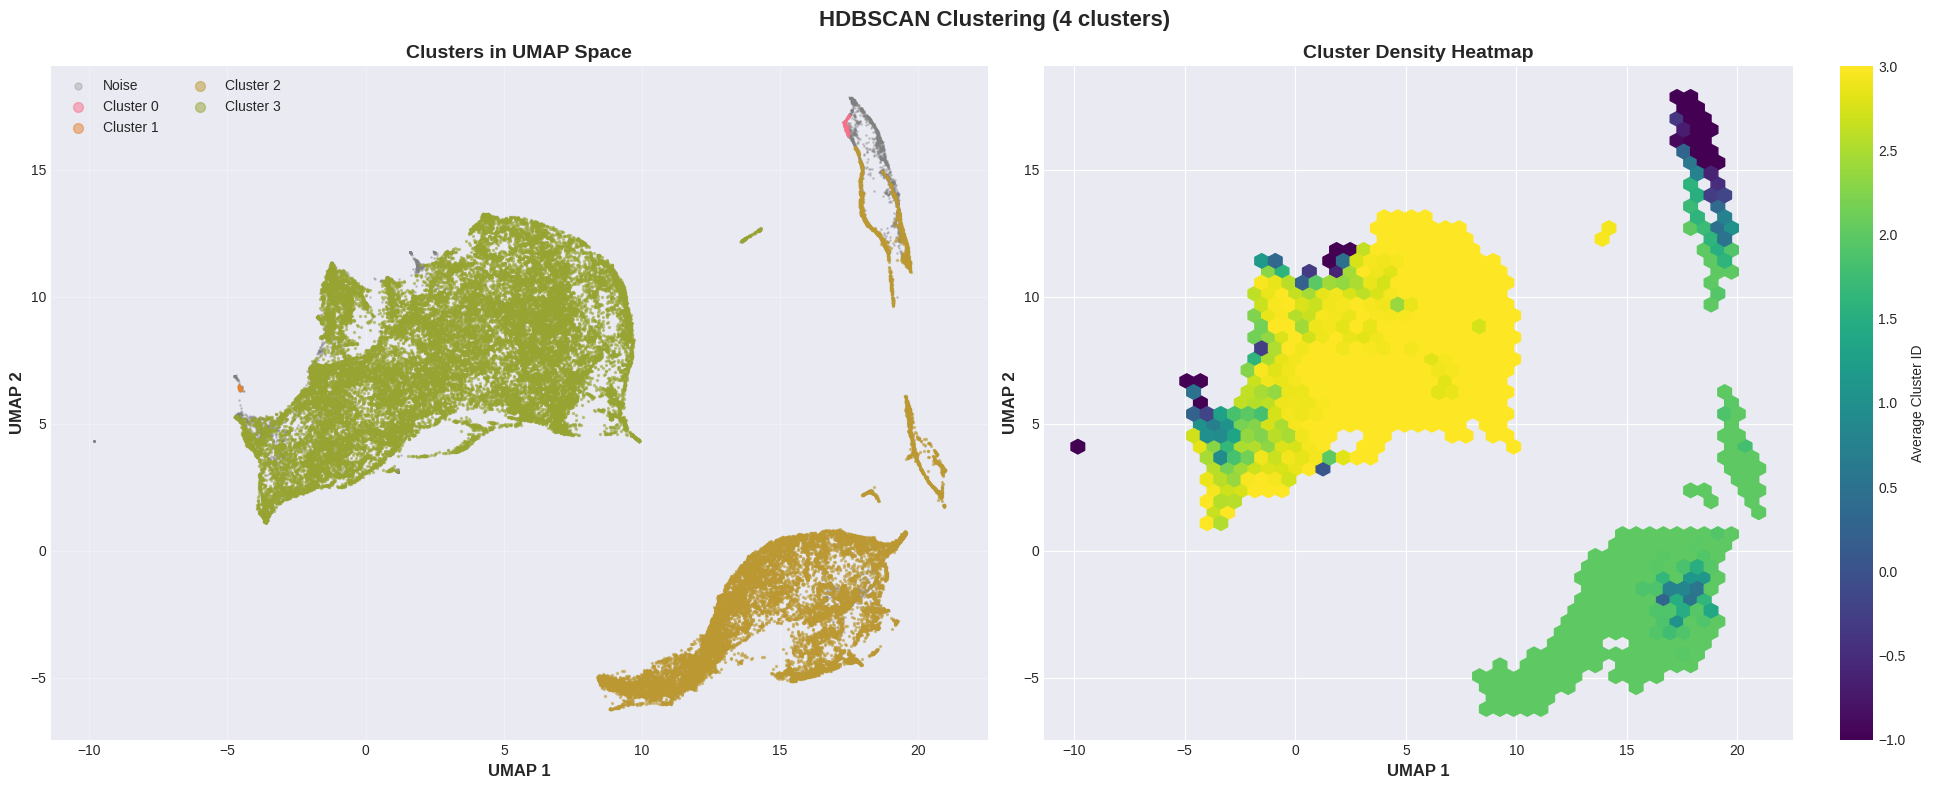

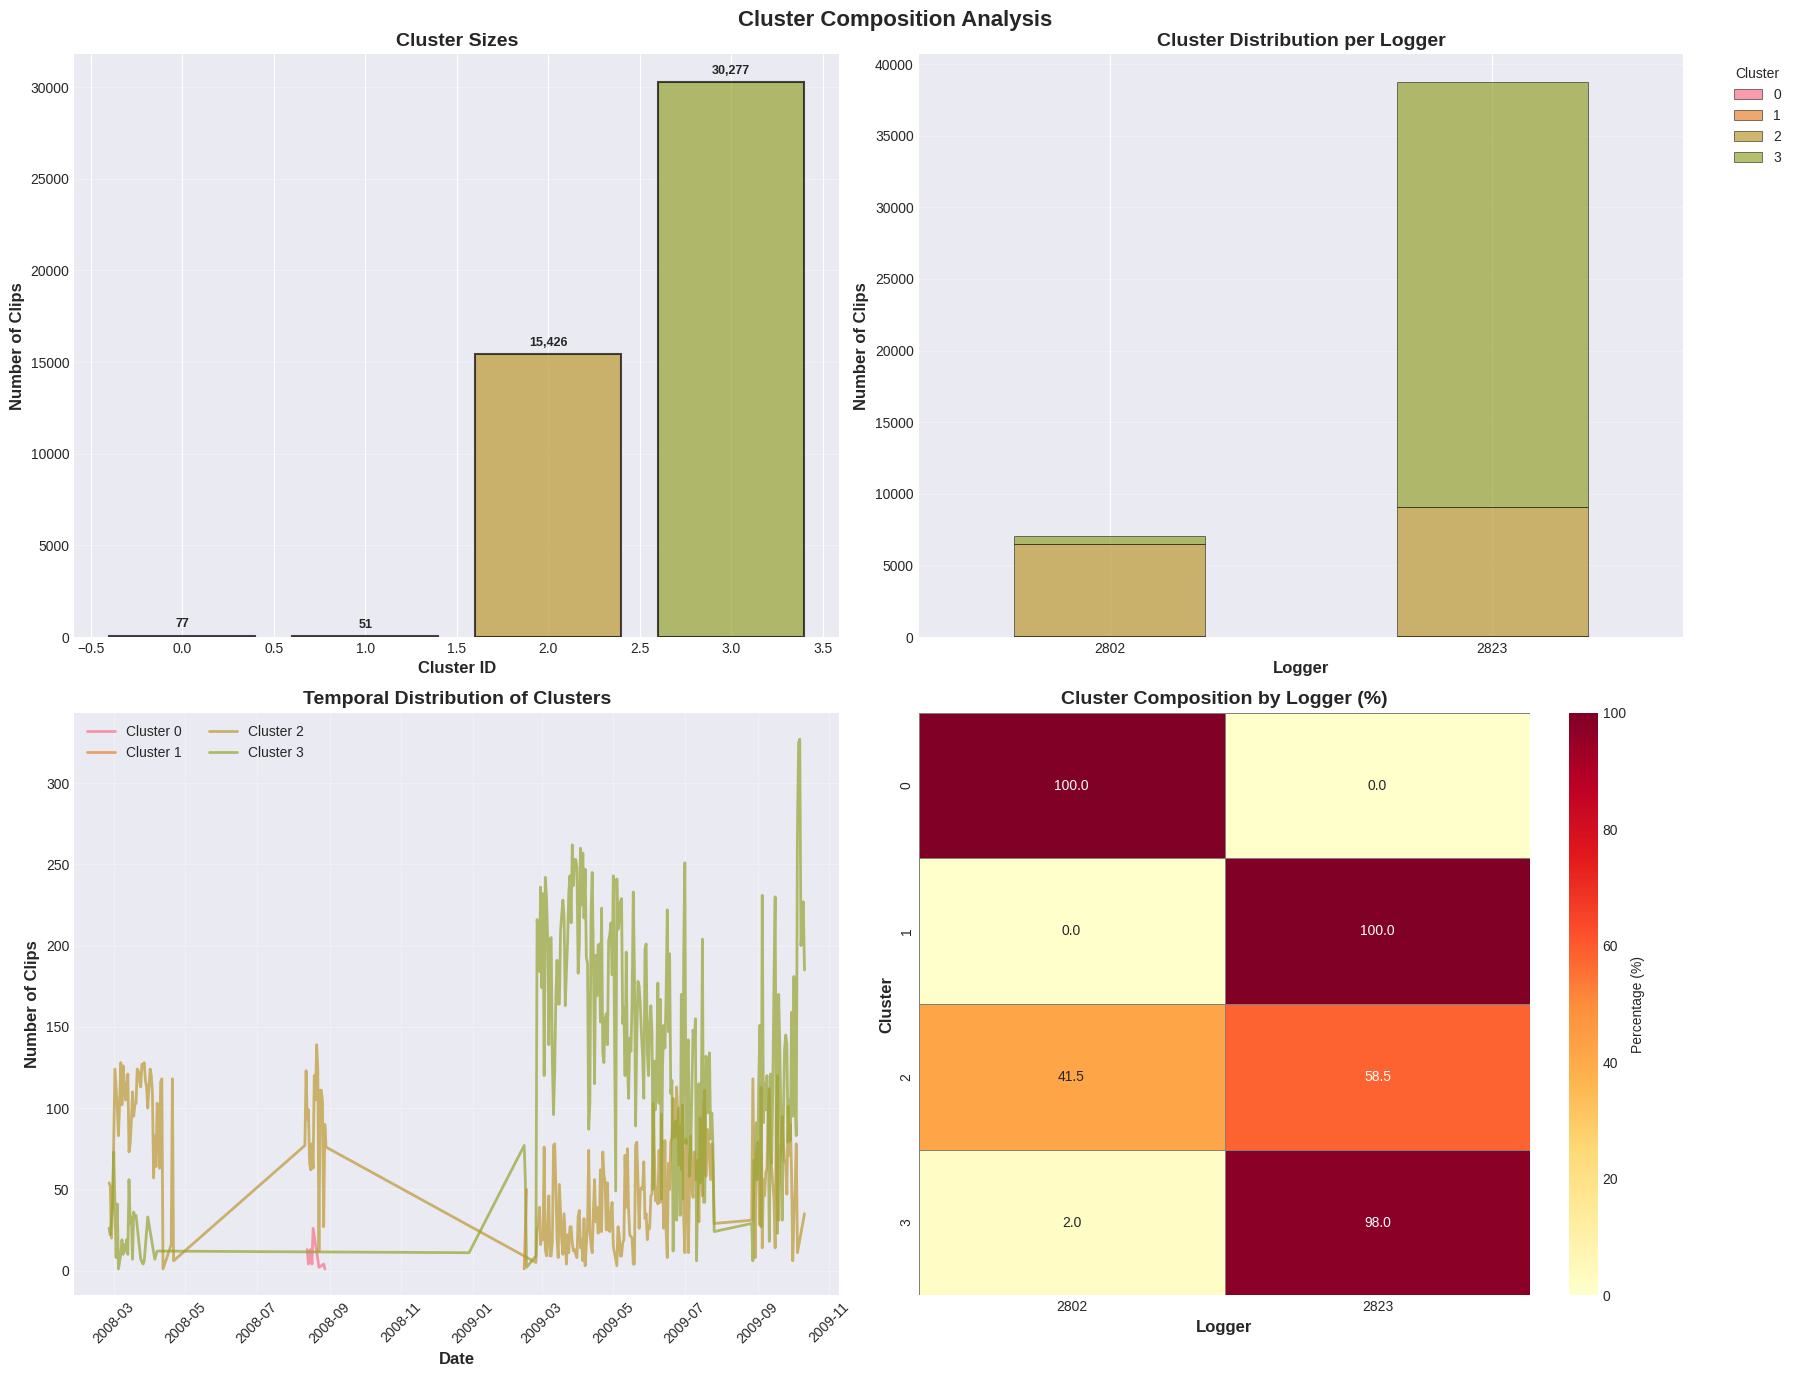

   ✓ Saved clustering results: clustered_data_hdbscan.parquet

STEP 4: Gaussian Mixture Model

🎯 Running GMM with 3 components...
   ✓ Silhouette score: 0.219
   ✓ Davies-Bouldin index: 1.807
   ✓ Calinski-Harabasz score: 5817.3
   ✓ Average confidence: 1.000

📊 Visualizing GMM clusters...


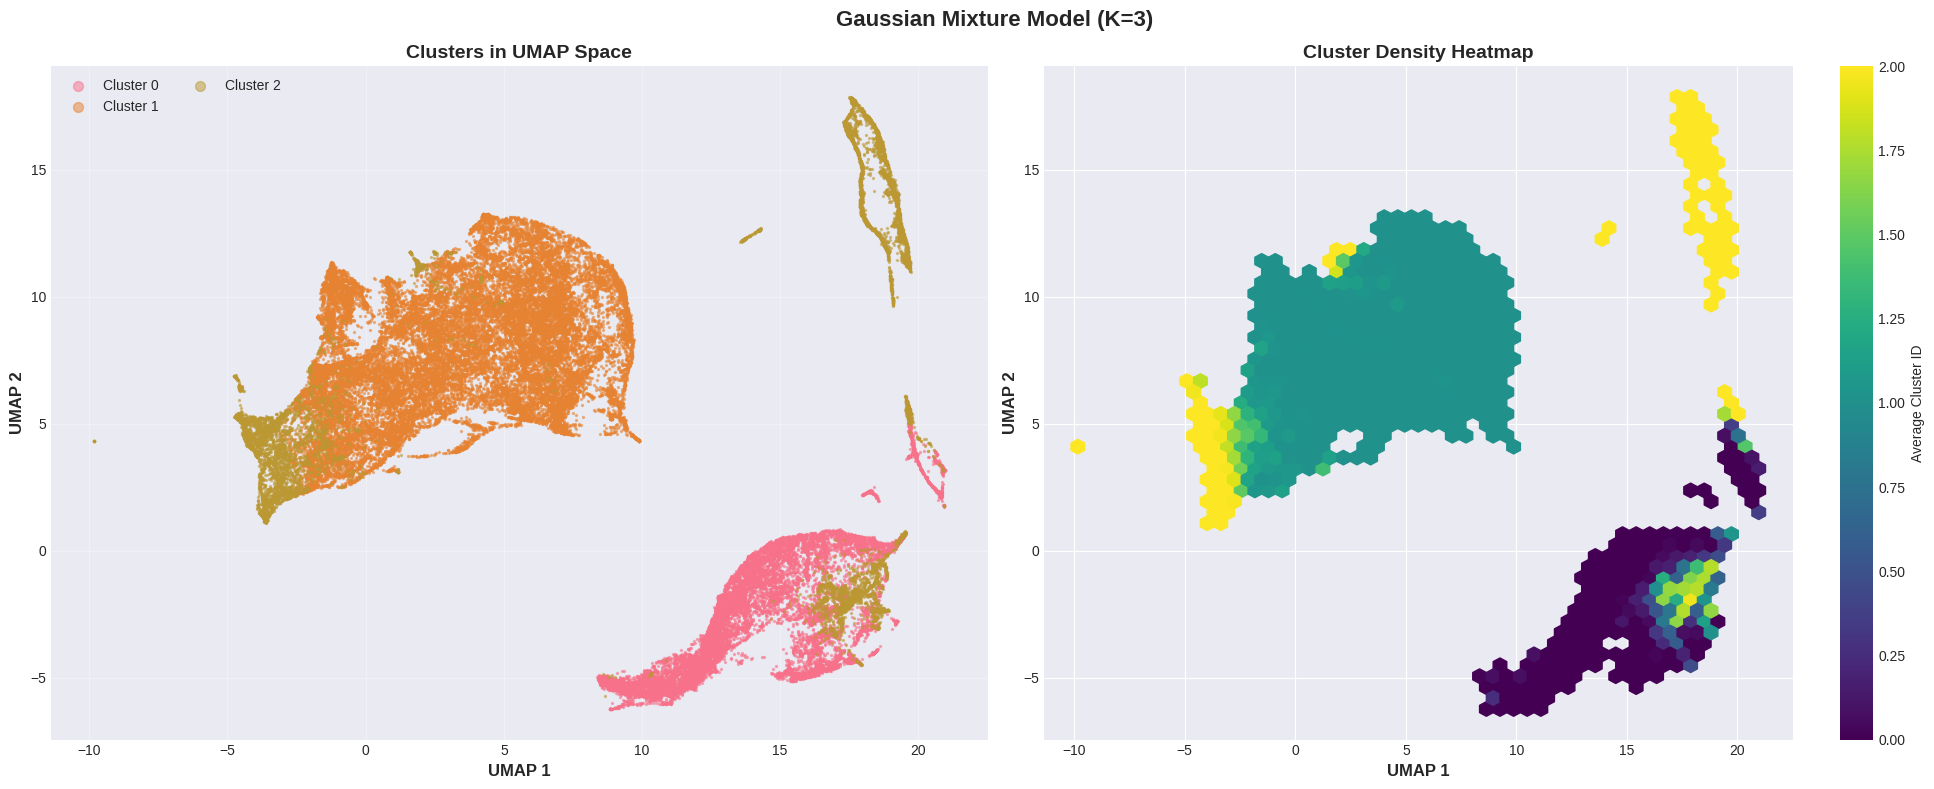

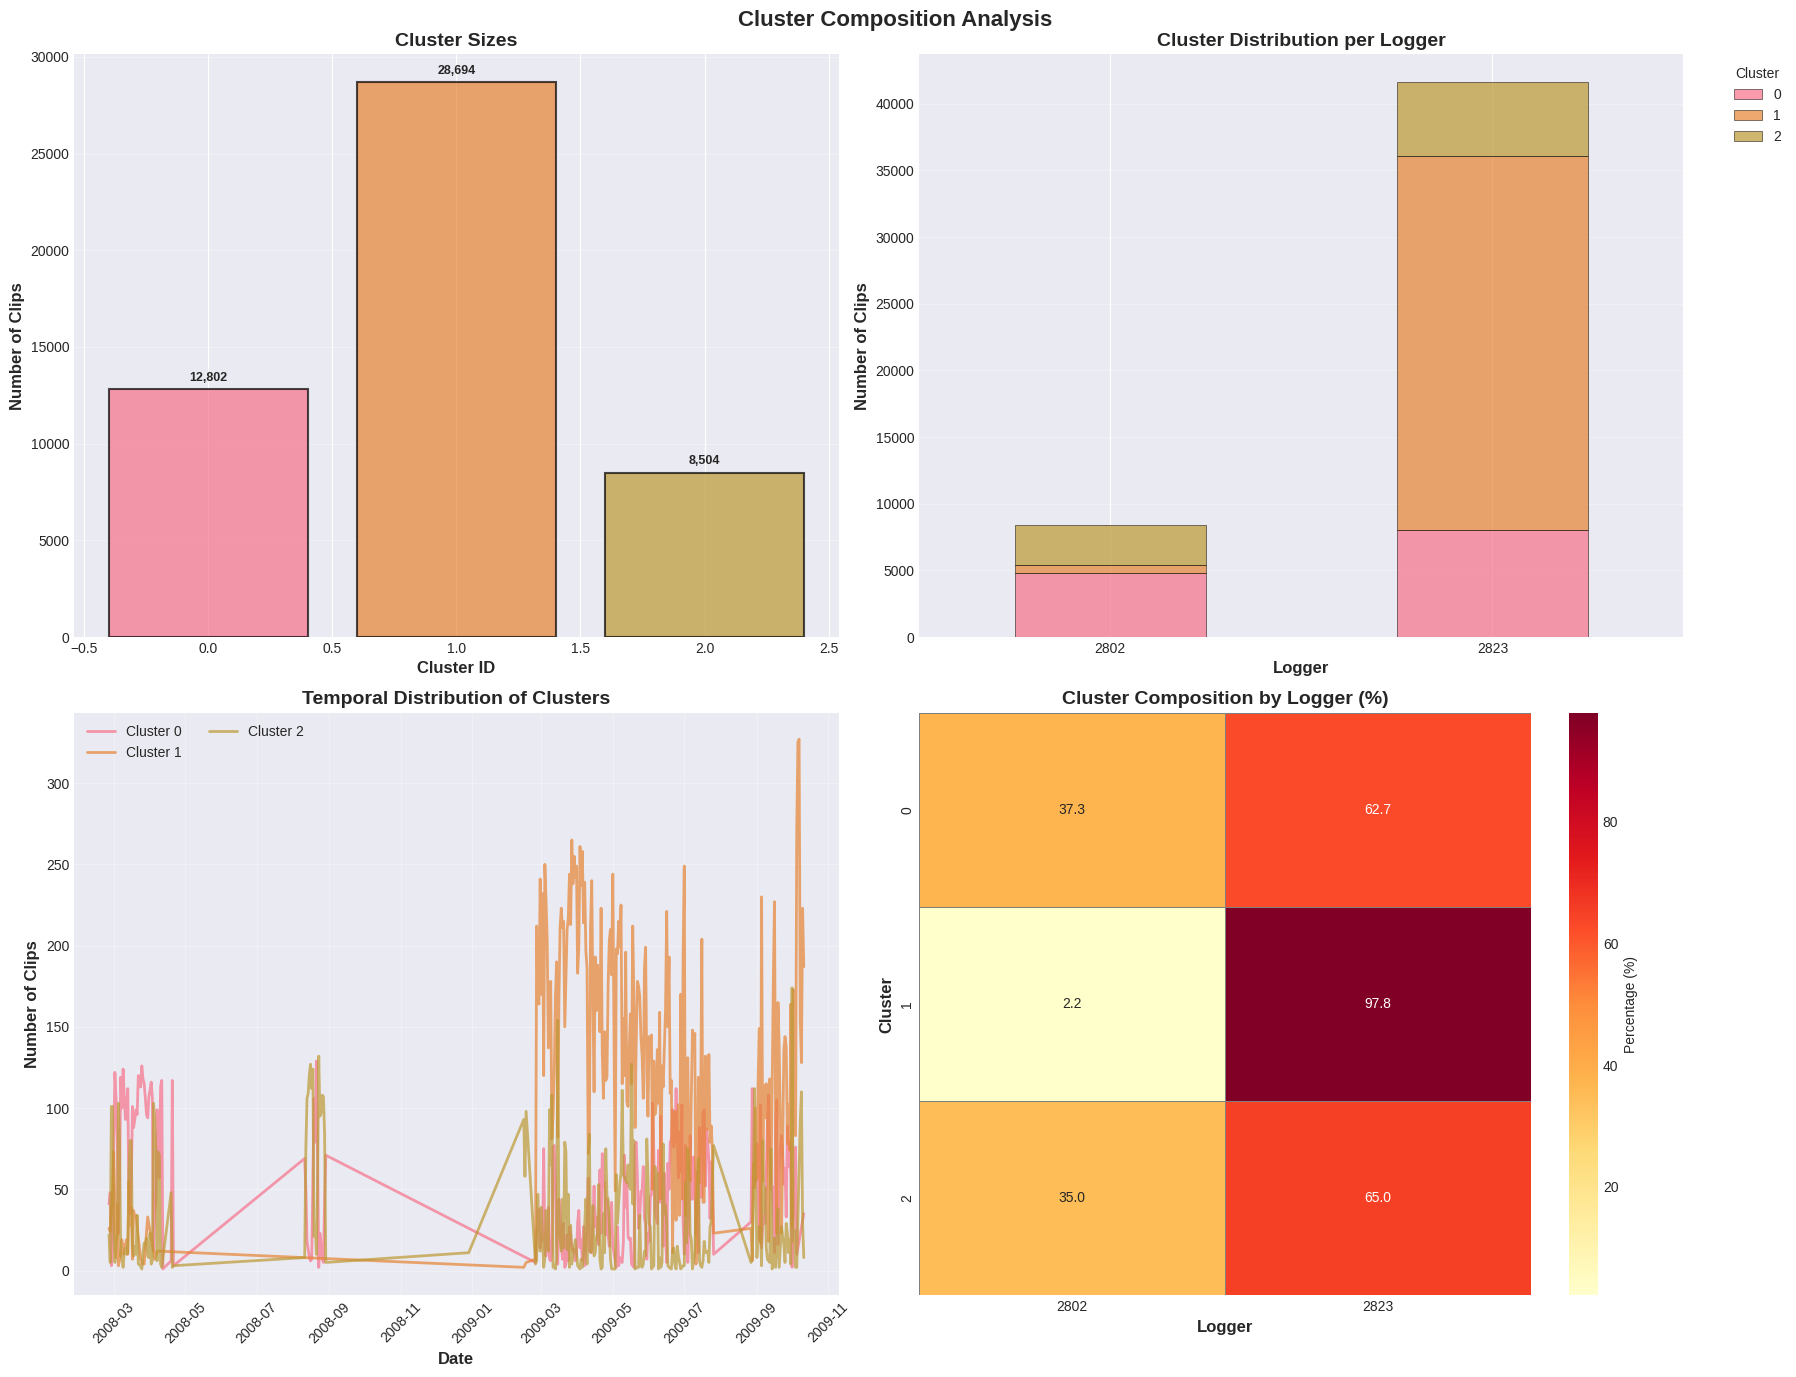

   ✓ Saved clustering results: clustered_data_gmm.parquet

STEP 5: Generating Summary Report
   ✓ Saved clustering report

✅ CLUSTERING COMPLETE

📊 Results Summary:

   K-Means (K=3):
      Silhouette: 0.769
      Davies-Bouldin: 0.729
      Calinski-Harabasz: 47437.2

   HDBSCAN:
      Clusters: 4
      Noise: 4,169 (8.3%)
      Silhouette: 0.271
      Davies-Bouldin: 1.025
      Calinski-Harabasz: 7412.7

   GMM (K=3):
      Silhouette: 0.219
      Davies-Bouldin: 1.807
      Calinski-Harabasz: 5817.3
      Avg Confidence: 1.000

💾 Output files saved to: data/clustering/results_50k
   📊 Visualizations (7 PNG files)
   📄 Data files (3 Parquet files)
   📝 Summary report (TXT file)

🎯 Next steps:
   1. Review the visualizations above and in the output folder
   2. Choose the best clustering method for your use case
   3. Use the clustered data for further analysis
   4. Listen to sample clips from each cluster to understand what they represent


In [21]:
def main():
    print("=" * 70)
    print("CLUSTERING ANALYSIS: K-Means, HDBSCAN, GMM")
    print("=" * 70)
    
    # Create output directory
    OUTPUT_BASE.mkdir(parents=True, exist_ok=True)
    
    # Load data
    metadata, features, umap_coords = load_preprocessed_data()
    
    # Store all results
    all_results = {}
    
    # 1. Find optimal K for K-means
    print("\n" + "="*70)
    print("STEP 1: Finding Optimal K")
    print("="*70)
    k_metrics = find_optimal_k_elbow(features, K_RANGE, OUTPUT_BASE)
    
    # Use the best K from silhouette score (or you can choose manually)
    optimal_k = k_metrics['best_k_silhouette']
    print(f"\n💡 Recommended K for K-means: {optimal_k}")
    
    # 2. K-Means with optimal K
    print("\n" + "="*70)
    print("STEP 2: K-Means Clustering")
    print("="*70)
    kmeans_labels, kmeans_model, kmeans_metrics = cluster_kmeans(features, optimal_k)
    all_results['kmeans'] = {
        'labels': kmeans_labels,
        'model': kmeans_model,
        'metrics': kmeans_metrics
    }
    
    # Plot K-means results
    print("\n📊 Visualizing K-means clusters...")
    plot_clusters_umap(umap_coords, kmeans_labels, metadata,
                      f'K-Means Clustering (K={optimal_k})',
                      OUTPUT_BASE / '02_kmeans_clusters.png')
    
    plot_cluster_analysis(kmeans_labels, metadata,
                         OUTPUT_BASE / '03_kmeans_analysis.png')
    
    save_clustering_results(metadata, features, kmeans_labels, 'kmeans', OUTPUT_BASE)
    
    # 3. HDBSCAN
    print("\n" + "="*70)
    print("STEP 3: HDBSCAN Clustering")
    print("="*70)
    hdbscan_labels, hdbscan_model, hdbscan_metrics = cluster_hdbscan(features, min_cluster_size=50)
    all_results['hdbscan'] = {
        'labels': hdbscan_labels,
        'model': hdbscan_model,
        'metrics': hdbscan_metrics
    }
    
    # Plot HDBSCAN results
    print("\n📊 Visualizing HDBSCAN clusters...")
    plot_clusters_umap(umap_coords, hdbscan_labels, metadata,
                      f'HDBSCAN Clustering ({hdbscan_metrics["n_clusters"]} clusters)',
                      OUTPUT_BASE / '04_hdbscan_clusters.png')
    
    plot_cluster_analysis(hdbscan_labels, metadata,
                         OUTPUT_BASE / '05_hdbscan_analysis.png')
    
    save_clustering_results(metadata, features, hdbscan_labels, 'hdbscan', OUTPUT_BASE)
    
    # 4. GMM with same K as K-means
    print("\n" + "="*70)
    print("STEP 4: Gaussian Mixture Model")
    print("="*70)
    gmm_labels, gmm_model, gmm_probas, gmm_metrics = cluster_gmm(features, optimal_k)
    all_results['gmm'] = {
        'labels': gmm_labels,
        'model': gmm_model,
        'probas': gmm_probas,
        'metrics': gmm_metrics
    }
    
    # Plot GMM results
    print("\n📊 Visualizing GMM clusters...")
    plot_clusters_umap(umap_coords, gmm_labels, metadata,
                      f'Gaussian Mixture Model (K={optimal_k})',
                      OUTPUT_BASE / '06_gmm_clusters.png')
    
    plot_cluster_analysis(gmm_labels, metadata,
                         OUTPUT_BASE / '07_gmm_analysis.png')
    
    save_clustering_results(metadata, features, gmm_labels, 'gmm', OUTPUT_BASE)
    
    # 5. Create comprehensive report
    print("\n" + "="*70)
    print("STEP 5: Generating Summary Report")
    print("="*70)
    create_clustering_report(all_results, OUTPUT_BASE)
    
    # Summary
    print("\n" + "=" * 70)
    print("✅ CLUSTERING COMPLETE")
    print("=" * 70)
    
    print(f"\n📊 Results Summary:")
    print(f"\n   K-Means (K={optimal_k}):")
    print(f"      Silhouette: {kmeans_metrics['silhouette']:.3f}")
    print(f"      Davies-Bouldin: {kmeans_metrics['davies_bouldin']:.3f}")
    print(f"      Calinski-Harabasz: {kmeans_metrics['calinski_harabasz']:.1f}")
    
    print(f"\n   HDBSCAN:")
    print(f"      Clusters: {hdbscan_metrics['n_clusters']}")
    print(f"      Noise: {hdbscan_metrics['n_noise']:,} ({hdbscan_metrics['n_noise']/len(features)*100:.1f}%)")
    if not np.isnan(hdbscan_metrics['silhouette']):
        print(f"      Silhouette: {hdbscan_metrics['silhouette']:.3f}")
        print(f"      Davies-Bouldin: {hdbscan_metrics['davies_bouldin']:.3f}")
        print(f"      Calinski-Harabasz: {hdbscan_metrics['calinski_harabasz']:.1f}")
    
    print(f"\n   GMM (K={optimal_k}):")
    print(f"      Silhouette: {gmm_metrics['silhouette']:.3f}")
    print(f"      Davies-Bouldin: {gmm_metrics['davies_bouldin']:.3f}")
    print(f"      Calinski-Harabasz: {gmm_metrics['calinski_harabasz']:.1f}")
    print(f"      Avg Confidence: {gmm_metrics['avg_confidence']:.3f}")
    
    print(f"\n💾 Output files saved to: {OUTPUT_BASE.relative_to(REPO_ROOT)}")
    print(f"   📊 Visualizations (7 PNG files)")
    print(f"   📄 Data files (3 Parquet files)")
    print(f"   📝 Summary report (TXT file)")
    
    print(f"\n🎯 Next steps:")
    print(f"   1. Review the visualizations above and in the output folder")
    print(f"   2. Choose the best clustering method for your use case")
    print(f"   3. Use the clustered data for further analysis")
    print(f"   4. Listen to sample clips from each cluster to understand what they represent")
    
    # IMPORTANT: Return the values
    return all_results, metadata, features, umap_coords

if __name__ == "__main__":
    results, metadata, features, umap_coords = main()